In [1]:
%pylab inline
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing, cross_validation
import scipy, scipy.stats, matplotlib
import statsmodels.formula.api as sm
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


/Users/vsquared/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
analytic_base = pd.read_csv('~/Repositories/datasets/analytic_base.csv')
analytic_qgiv = pd.read_csv('~/Repositories/datasets/analytic_qgiv_stats.csv')

ab = analytic_base[['id', 'org', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol']]
aq = analytic_qgiv[['id', 'base', 'org', 'total_visits', 'opt_fields', 'req_fields', 'donation_active', 'amounts_system', 'multirestriction_system', 'restrictions', 'pledges_count', 'pledge_active', 'permit_anonymous', 'permit_mobile', 'permit_other_amount', 'enable_donorlogins', 'collect_captcha']]
d = pd.merge(ab, aq, left_on="id", right_on="base")

In [3]:
# filter out not visited observations
data = d[d.visits > 0]
# add conversion
conversion = pd.DataFrame({'conversion':data["don_form_trans_count"]/data["total_visits"]*100})
# merge conversion w/ the rest of the data
data = pd.concat([data, conversion], axis=1)
# add day_of_month & month
date_data = pd.DataFrame({
        'day': pd.to_datetime(data.timestamp).apply(lambda x: x.day), 
        'month': pd.to_datetime(data.timestamp).apply(lambda x: x.month)})
# merge date data w/ the rest of the data
data = pd.concat([data, date_data], axis=1)

# add restrictionsXmultirestriction interaction term, restrictions^2, opt_fields^2, req_fields^2
data['restrictionsXmultirestriction'] = data.restrictions*data.multirestriction_system
data['restrictions2'] = data.restrictions*data.restrictions
data['restrictions2Xmultirestriction'] = data.restrictions2*data.multirestriction_system
data['restrictions3'] = data.restrictions*data.restrictions*data.restrictions
data['restrictions3Xmultirestriction'] = data.restrictions3*data.multirestriction_system
data['opt_fields2'] = data.opt_fields*data.opt_fields
data['opt_fields3'] = data.opt_fields*data.opt_fields*data.opt_fields
data['req_fields2'] = data.req_fields*data.req_fields
data['req_fields3'] = data.req_fields*data.req_fields*data.req_fields
data['fields'] = data['opt_fields'] + data['req_fields']
data['fields2'] = data['fields']*data['fields']
data['fields3'] = data['fields']*data['fields']*data['fields']
data['is_payday'] = data.day.apply(lambda x: x in [1, 15, 30, 31])

Adding complexity features

* restrictionsXmultirestriction
* restrictions^2
* restrictions^2Xmultirestriction
* restrictions^3
* restrictions^3Xmultirestriction
* opt_fields^2
* opt_fields^3
* req_fields^2
* req_fields^3
* fields
* fields^2
* fields^3

## StatsModels OLS analysis

In [4]:
features = data.copy()

# remove irrelevant features
to_remove = ['amounts_system', 'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base', 'org_y', 'total_visits', 'conversion']
for i_to_remove in to_remove:
    del features[i_to_remove]

# normalize features
features_scaled = preprocessing.scale(features)

In [5]:
features.columns.values

array(['opt_fields', 'req_fields', 'donation_active',
       'multirestriction_system', 'restrictions', 'pledges_count',
       'pledge_active', 'permit_anonymous', 'permit_mobile',
       'permit_other_amount', 'enable_donorlogins', 'collect_captcha',
       'day', 'month', 'restrictionsXmultirestriction', 'restrictions2',
       'restrictions2Xmultirestriction', 'restrictions3',
       'restrictions3Xmultirestriction', 'opt_fields2', 'opt_fields3',
       'req_fields2', 'req_fields3', 'fields', 'fields2', 'fields3',
       'is_payday'], dtype=object)

In [6]:
data['Eins'] = np.ones((len(data), ))

Y = data.conversion[:-1]
X = features_scaled[:-1]
fit = sm.OLS(Y, X).fit()
print fit.summary()

del data['Eins']

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     262.3
Date:                Fri, 19 May 2017   Prob (F-statistic):               0.00
Time:                        14:23:07   Log-Likelihood:            -2.3603e+06
No. Observations:              569721   AIC:                         4.721e+06
Df Residuals:                  569695   BIC:                         4.721e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          3.763e+09    8.1e+10      0.046      0.9

In [7]:
print fit.params
abs(fit.params).sort_values().keys()

x1       3.762667e+09
x2       1.953456e+09
x3       5.649635e-01
x4       7.108948e-01
x5       1.658304e+00
x6       1.167345e-01
x7      -3.772220e-01
x8      -5.977840e-02
x9       1.704972e-01
x10      6.069526e-02
x11      3.629263e-01
const   -2.984702e-07
x12      1.672625e-01
x13     -1.589659e-01
x14      8.359120e-01
x15     -3.713399e+00
x16     -1.047110e+00
x17      2.096071e+00
x18      6.505392e-01
x19     -5.464692e+00
x20      4.649898e+00
x21     -2.182237e+00
x22      2.783970e+00
x23     -4.448121e+09
x24      5.130820e+00
x25     -4.848250e+00
x26      1.948154e-01
dtype: float64


Index([u'const', u'x8', u'x10', u'x6', u'x13', u'x12', u'x9', u'x26', u'x11',
       u'x7', u'x3', u'x18', u'x4', u'x14', u'x16', u'x5', u'x17', u'x21',
       u'x22', u'x15', u'x20', u'x25', u'x24', u'x19', u'x2', u'x1', u'x23'],
      dtype='object')

# Required field model testing

In [8]:
mdl = linear_model.LinearRegression()
mdl.fit(features, data.conversion)
mdl_scaled = linear_model.LinearRegression()
mdl_scaled.fit(features_scaled, data.conversion)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

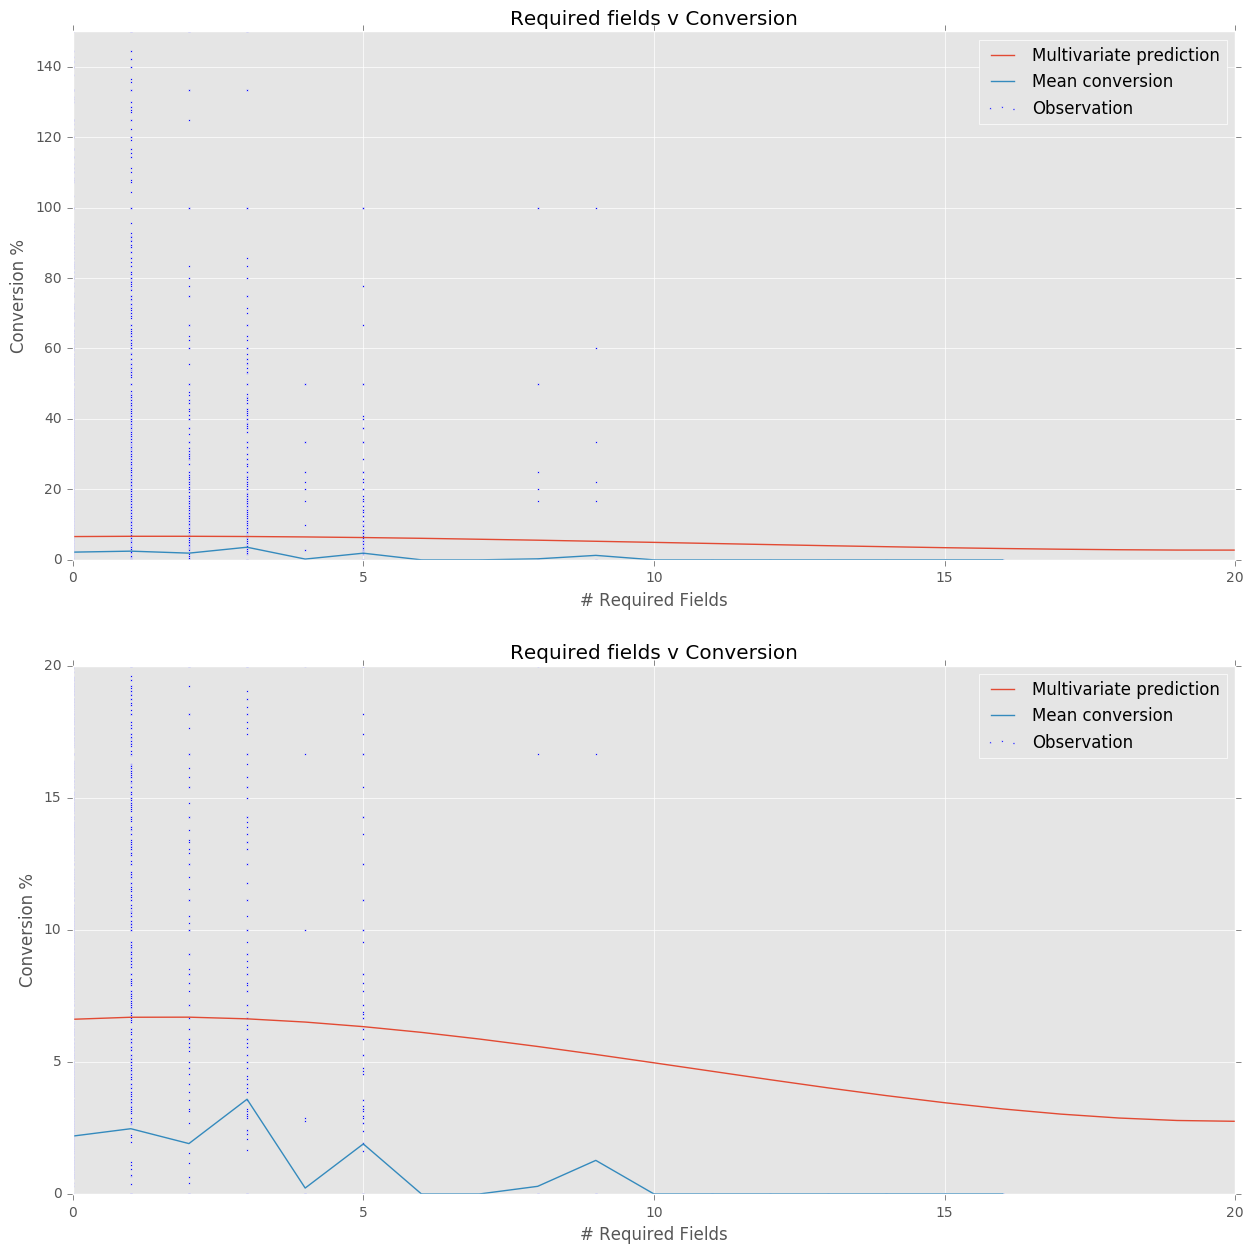

SCALED COEFFICIENTS
opt_fields: -8195960123.2
req_fields: -4255079243.73
donation_active: 0.5649766922
multirestriction_system: 0.710903167725
restrictions: 1.65829372406
pledges_count: 0.116732120514
pledge_active: -0.377219796181
permit_anonymous: -0.0597767829895
permit_mobile: 0.170493841171
permit_other_amount: 0.0606969594955
enable_donorlogins: 0.362924337387
collect_captcha: -4.76837158203e-07
day: 0.167265690863
month: -0.158969730139
restrictionsXmultirestriction: 0.835911750793
restrictions2: -3.71337154508
restrictions2Xmultirestriction: -1.04710829258
restrictions3: 2.09605628252
restrictions3Xmultirestriction: 0.650539070368
opt_fields2: -5.4647026062
opt_fields3: 4.64990139008
req_fields2: -2.18223893642
req_fields3: 2.78396987915
fields: 9689037956.1
fields2: 5.13083040714
fields3: -4.84825450182
is_payday: 0.194813653827


In [10]:
# generate prediction data
example = data[data.conversion>0][1:2]

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 200):
    example['req_fields'] = i
    example['req_fields2'] = i*i
    example['req_fields3'] = i*i*i
    example['fields'] = i+example['opt_fields']
    example['fields2'] = example['fields']*example['fields']
    example['fields3'] = example['fields']*example['fields']*example['fields']
    predictions.append(mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(data[data.req_fields==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(15,15))
plt.subplot(211)
plt.scatter(data.req_fields, data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Required fields v Conversion")
xlim(0, 20)
ylim(0, 150)
xlabel('# Required Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(data.req_fields, data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Required fields v Conversion")
xlim(0, 20)
ylim(0, 20)
xlabel('# Required Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()
print "SCALED COEFFICIENTS"
scaled_coefs = mdl_scaled.coef_
for i in range(0, len(features.columns.values)):
    print features.columns.values[i]+": "+str(scaled_coefs[i])
    
req_field_predictions = predictions

* consider removing data points where required fields > 5

## Optional field model testing

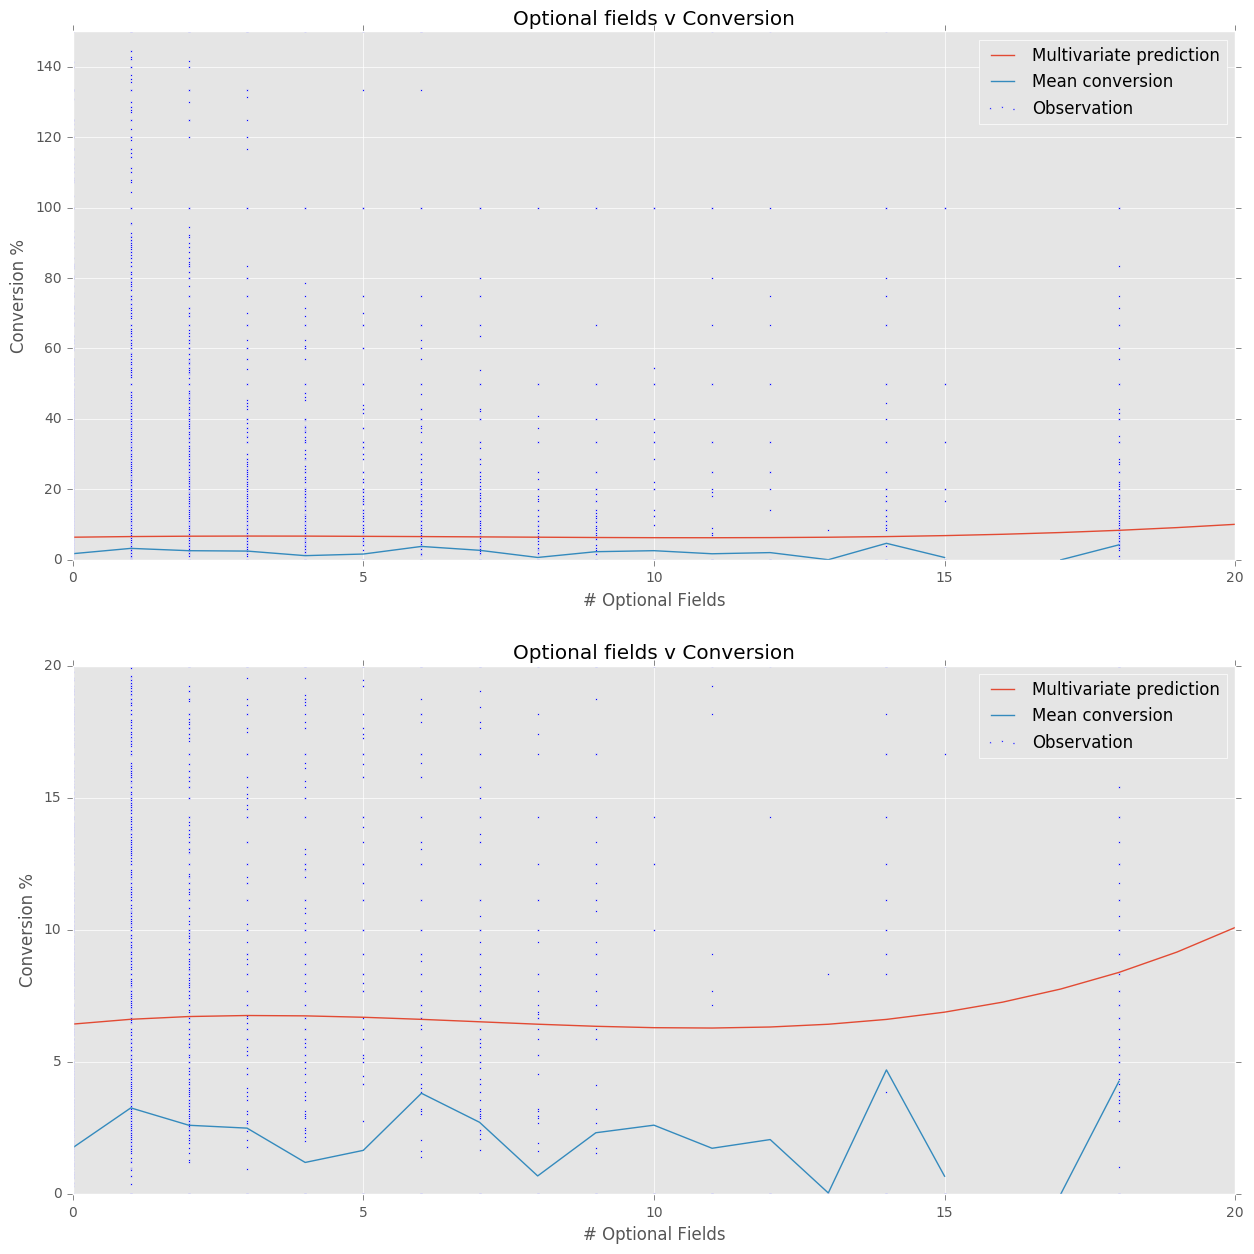

SCALED COEFFICIENTS
opt_fields: -8195960123.2
req_fields: -4255079243.73
donation_active: 0.5649766922
multirestriction_system: 0.710903167725
restrictions: 1.65829372406
pledges_count: 0.116732120514
pledge_active: -0.377219796181
permit_anonymous: -0.0597767829895
permit_mobile: 0.170493841171
permit_other_amount: 0.0606969594955
enable_donorlogins: 0.362924337387
collect_captcha: -4.76837158203e-07
day: 0.167265690863
month: -0.158969730139
restrictionsXmultirestriction: 0.835911750793
restrictions2: -3.71337154508
restrictions2Xmultirestriction: -1.04710829258
restrictions3: 2.09605628252
restrictions3Xmultirestriction: 0.650539070368
opt_fields2: -5.4647026062
opt_fields3: 4.64990139008
req_fields2: -2.18223893642
req_fields3: 2.78396987915
fields: 9689037956.1
fields2: 5.13083040714
fields3: -4.84825450182
is_payday: 0.194813653827


In [11]:
# generate prediction data
example = data[data.conversion>0][1:2]

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 200):
    example['opt_fields'] = i
    example['opt_fields2'] = i*i
    example['opt_fields3'] = i*i*i
    example['fields'] = i+example['req_fields']
    example['fields2'] = example['fields']*example['fields']
    example['fields3'] = example['fields']*example['fields']*example['fields']
    predictions.append(mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(data[data.opt_fields==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(15,15))
plt.subplot(211)
plt.scatter(data.opt_fields, data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Optional fields v Conversion")
xlim(0, 20)
ylim(0, 150)
xlabel('# Optional Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(data.opt_fields, data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion")
plt.title("Optional fields v Conversion")
xlim(0, 20)
ylim(0, 20)
xlabel('# Optional Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()
print "SCALED COEFFICIENTS"
scaled_coefs = mdl_scaled.coef_
for i in range(0, len(features.columns.values)):
    print features.columns.values[i]+": "+str(scaled_coefs[i])
    
opt_field_predictions = predictions

* consider removing data points where optional fields > 5

## Looking at conversion across both required & optional fields

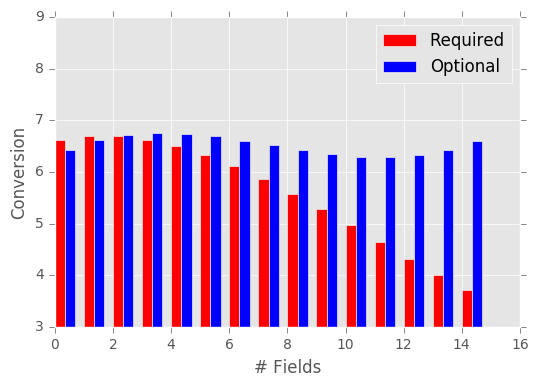

In [12]:
N = np.arange(15)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(N, req_field_predictions[0:15], width, color='r')
rects2 = ax.bar(N+width, opt_field_predictions[0:15], width, color='b')

ax.set_ylim(3, 9)
ax.set_ylabel("Conversion")
ax.set_xlabel("# Fields")
ax.legend((rects1[0], rects2[0]), ('Required', 'Optional'))

plt.show()

## Looking for outliers

In [13]:
data[['org_x', 'form', 'req_fields', 'opt_fields', 'fields']][data.opt_fields>12]

,org_x,form,req_fields,opt_fields,fields
3236,333,711,0.0,18.0,18.0
3245,333,794,0.0,15.0,15.0
5115,333,711,0.0,18.0,18.0
5398,113,87,0.0,14.0,14.0
5833,333,711,0.0,18.0,18.0
8634,516,488,0.0,17.0,17.0
8953,516,488,0.0,17.0,17.0
10855,113,87,0.0,14.0,14.0
11028,333,711,0.0,18.0,18.0
12524,516,488,0.0,17.0,17.0


Outliers:
* Org: 27626, 6 or so forms - lots with 14 - 15 required fields
* Org: 9169, form: 820343 - 32 required fields, hobnob event, somehow?
* Org: 880, form: 812122 - 15 required fields, using restrictions as event registration
* Org: 333, form: 711 - 18 optional fields
* Org: 113, form: 87 - 14 optional fields, CURRENTLY REDUCED TO 7 -- INVESTIGATED, not enough data to interpret change

## Retraining w/out outliers

In [14]:
# copy & remove outliers
data_len = len(data)

nrm_data = data.copy()
# remove outlier orgs & forms
nrm_data = nrm_data[nrm_data.org_x!=27626]
nrm_data = nrm_data[nrm_data.form!=820343]
nrm_data = nrm_data[nrm_data.form!=812122]
nrm_data = nrm_data[nrm_data.form!=711]
nrm_data = nrm_data[nrm_data.form!=87]
# remove higher field counts
nrm_data = nrm_data[nrm_data.req_fields<8]
nrm_data = nrm_data[nrm_data.opt_fields<10]
# remove higher conversion at higher field counts to reshape curve
rm_indexes = (nrm_data.opt_fields > 5) & (nrm_data.conversion > 60)
nrm_data = nrm_data[~rm_indexes]
rm_indexes = (nrm_data.opt_fields > 7) & (nrm_data.conversion > 40)
nrm_data = nrm_data[~rm_indexes]

nrm_data_len = len(nrm_data)

print str(nrm_data_len)+" observations out of "+str(data_len)+" original observations"

558680 observations out of 569722 original observations


In [15]:
nrm_data.columns.values

array(['id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits',
       'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base',
       'org_y', 'total_visits', 'opt_fields', 'req_fields',
       'donation_active', 'amounts_system', 'multirestriction_system',
       'restrictions', 'pledges_count', 'pledge_active',
       'permit_anonymous', 'permit_mobile', 'permit_other_amount',
       'enable_donorlogins', 'collect_captcha', 'conversion', 'day',
       'month', 'restrictionsXmultirestriction', 'restrictions2',
       'restrictions2Xmultirestriction', 'restrictions3',
       'restrictions3Xmultirestriction', 'opt_fields2', 'opt_fields3',
       'req_fields2', 'req_fields3', 'fields', 'fields2', 'fields3',
       'is_payday'], dtype=object)

In [16]:
nrm_data.day.describe()

count    558680.000000
mean         15.302064
std           8.924186
min           1.000000
25%           7.000000
50%          15.000000
75%          23.000000
max          31.000000
Name: day, dtype: float64

In [17]:
# rebuild feature matrix
nrm_features = nrm_data.copy()

# remove irrelevant features
to_remove = ['amounts_system', 'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base', 'org_y', 'total_visits', 'conversion']
for i_to_remove in to_remove:
    del nrm_features[i_to_remove]

# normalize features
nrm_features_scaled = preprocessing.scale(nrm_features)

### OLS summary

In [18]:
# OLS stats
nrm_data['Eins'] = np.ones((len(nrm_data), ))

Y = nrm_data.conversion[:-1]
X = nrm_features_scaled[:-1]
fit = sm.OLS(Y, X).fit()
print fit.summary()

del nrm_data['Eins']

                            OLS Regression Results                            
Dep. Variable:             conversion   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     264.3
Date:                Fri, 19 May 2017   Prob (F-statistic):               0.00
Time:                        14:23:38   Log-Likelihood:            -2.3108e+06
No. Observations:              558679   AIC:                         4.622e+06
Df Residuals:                  558653   BIC:                         4.622e+06
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1         -5.757e+09    7.6e+10     -0.076      0.9

### Required field model testing

In [19]:
nrm_mdl = linear_model.LinearRegression()
nrm_mdl.fit(nrm_features, nrm_data.conversion)
nrm_mdl_scaled = linear_model.LinearRegression()
nrm_mdl_scaled.fit(nrm_features_scaled, nrm_data.conversion)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

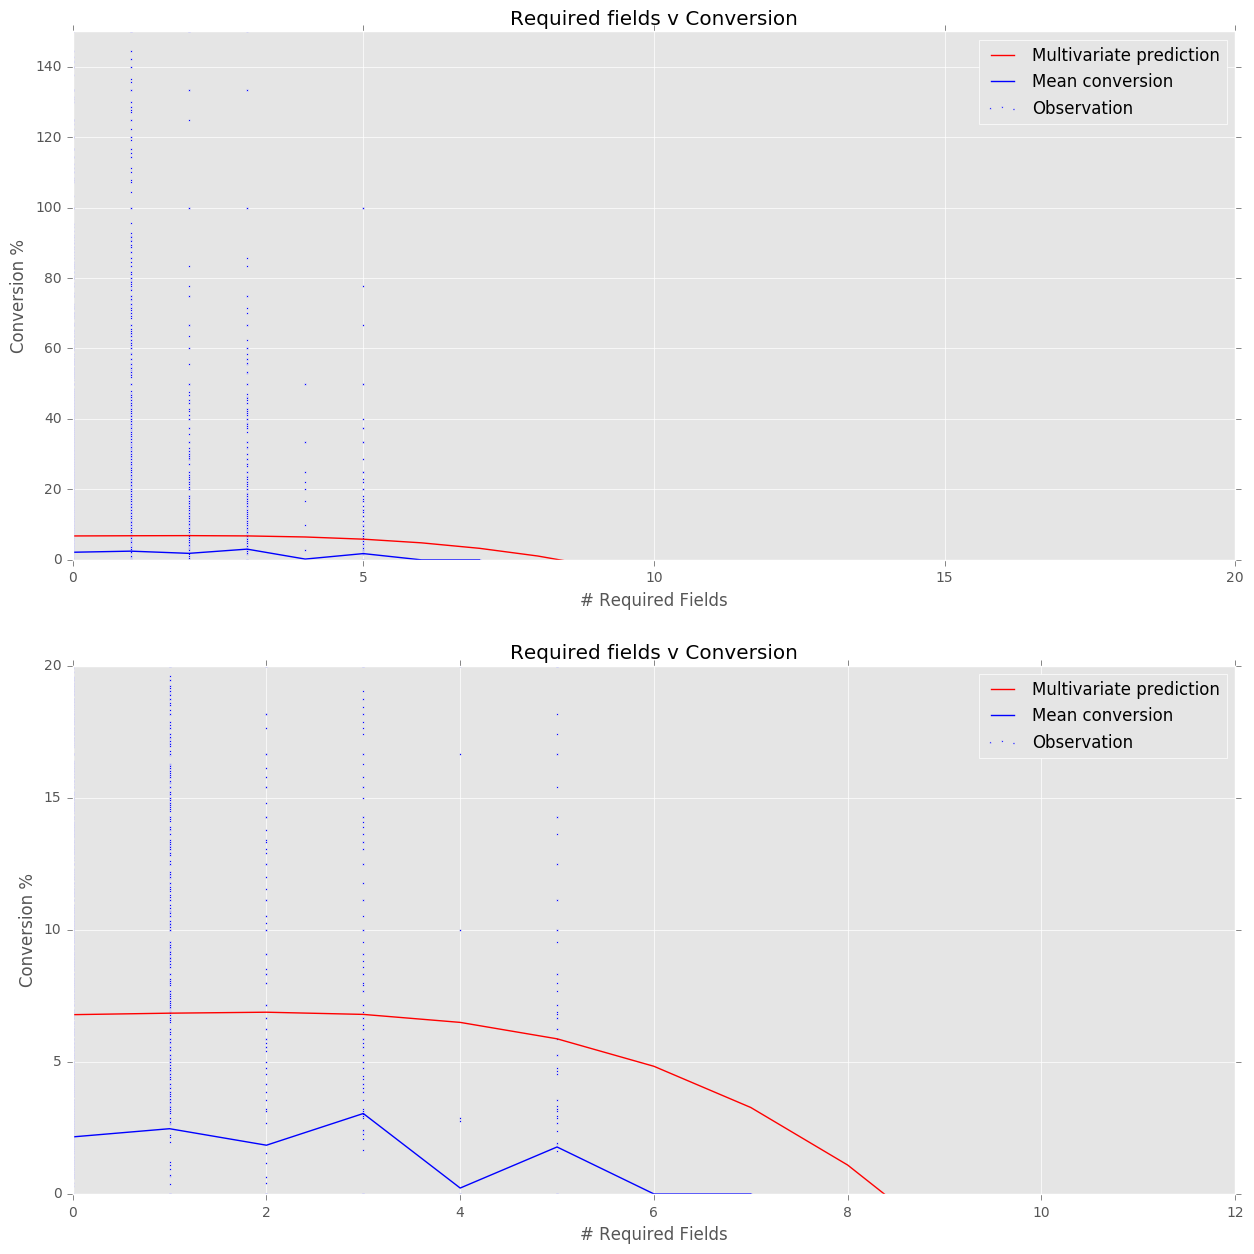

SCALED COEFFICIENTS
opt_fields: -8195960123.2
req_fields: -4255079243.73
donation_active: 0.5649766922
multirestriction_system: 0.710903167725
restrictions: 1.65829372406
pledges_count: 0.116732120514
pledge_active: -0.377219796181
permit_anonymous: -0.0597767829895
permit_mobile: 0.170493841171
permit_other_amount: 0.0606969594955
enable_donorlogins: 0.362924337387
collect_captcha: -4.76837158203e-07
day: 0.167265690863
month: -0.158969730139
restrictionsXmultirestriction: 0.835911750793
restrictions2: -3.71337154508
restrictions2Xmultirestriction: -1.04710829258
restrictions3: 2.09605628252
restrictions3Xmultirestriction: 0.650539070368
opt_fields2: -5.4647026062
opt_fields3: 4.64990139008
req_fields2: -2.18223893642
req_fields3: 2.78396987915
fields: 9689037956.1
fields2: 5.13083040714
fields3: -4.84825450182
is_payday: 0.194813653827


In [20]:
# generate prediction data
example = nrm_data[nrm_data.conversion>0][1:2]

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 200):
    example['req_fields'] = i
    example['req_fields2'] = i*i
    example['req_fields3'] = i*i*i
    example['fields'] = i+example['opt_fields']
    example['fields2'] = example['fields']*example['fields']
    example['fields3'] = example['fields']*example['fields']*example['fields']
    predictions.append(nrm_mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(nrm_data[nrm_data.req_fields==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(15,15))
plt.subplot(211)
plt.scatter(nrm_data.req_fields, nrm_data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction", color="red")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion", color="blue")
plt.title("Required fields v Conversion")
xlim(0, 20)
ylim(0, 150)
xlabel('# Required Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(nrm_data.req_fields, nrm_data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction", color="red")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion", color="blue")
plt.title("Required fields v Conversion")
xlim(0, 12)
ylim(0, 20)
xlabel('# Required Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()
print "SCALED COEFFICIENTS"
scaled_coefs = mdl_scaled.coef_
for i in range(0, len(features.columns.values)):
    print features.columns.values[i]+": "+str(scaled_coefs[i])
    
req_field_predictions = predictions

Looks like required field predicting is following the mean conversion trend for required fields. Variance is too high to predict value but can still be used to predict delta ("adding a required field will decrease the conversion rate by 0.2%" or something of the like).

### Optional field model testing w/out outliers

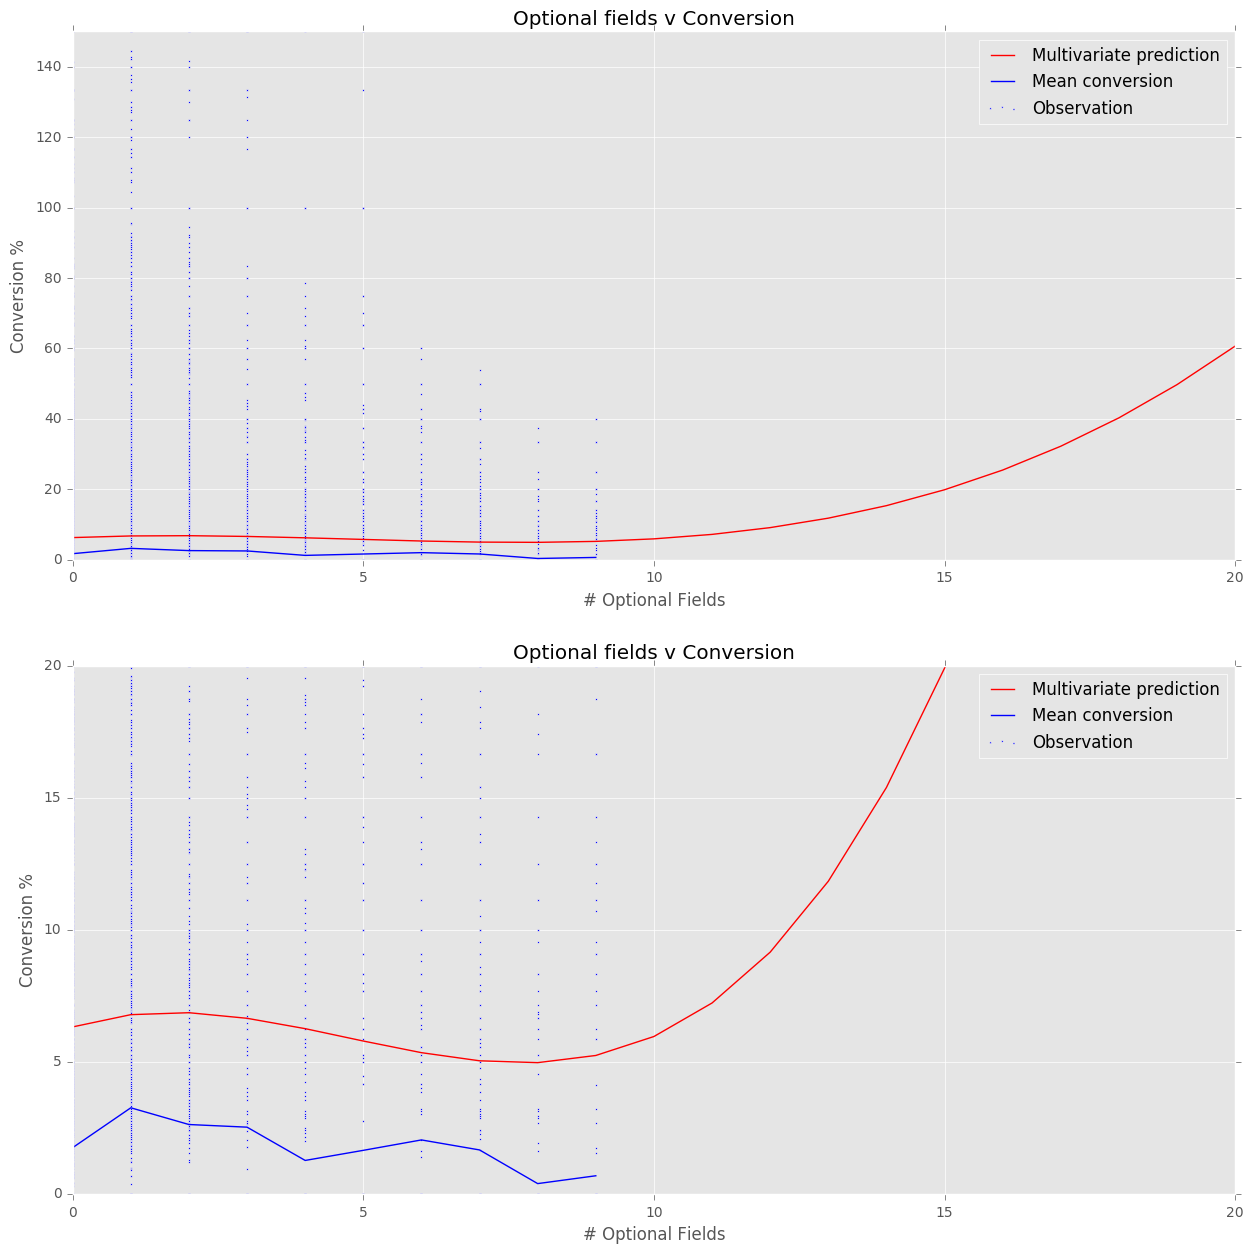

SCALED COEFFICIENTS
opt_fields: -8195960123.2
req_fields: -4255079243.73
donation_active: 0.5649766922
multirestriction_system: 0.710903167725
restrictions: 1.65829372406
pledges_count: 0.116732120514
pledge_active: -0.377219796181
permit_anonymous: -0.0597767829895
permit_mobile: 0.170493841171
permit_other_amount: 0.0606969594955
enable_donorlogins: 0.362924337387
collect_captcha: -4.76837158203e-07
day: 0.167265690863
month: -0.158969730139
restrictionsXmultirestriction: 0.835911750793
restrictions2: -3.71337154508
restrictions2Xmultirestriction: -1.04710829258
restrictions3: 2.09605628252
restrictions3Xmultirestriction: 0.650539070368
opt_fields2: -5.4647026062
opt_fields3: 4.64990139008
req_fields2: -2.18223893642
req_fields3: 2.78396987915
fields: 9689037956.1
fields2: 5.13083040714
fields3: -4.84825450182
is_payday: 0.194813653827


In [21]:
# generate prediction data
example = nrm_data[nrm_data.conversion>0][1:2]

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 200):
    example['opt_fields'] = i
    example['opt_fields2'] = i*i
    example['opt_fields3'] = i*i*i
    example['fields'] = i+example['req_fields']
    example['fields2'] = example['fields']*example['fields']
    example['fields3'] = example['fields']*example['fields']*example['fields']
    predictions.append(nrm_mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(nrm_data[nrm_data.opt_fields==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(15,15))
plt.subplot(211)
plt.scatter(nrm_data.opt_fields, nrm_data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction", color="red")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion", color="blue")
plt.title("Optional fields v Conversion")
xlim(0, 20)
ylim(0, 150)
xlabel('# Optional Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(nrm_data.opt_fields, nrm_data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction", color="red")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion", color="blue")
plt.title("Optional fields v Conversion")
xlim(0, 20)
ylim(0, 20)
xlabel('# Optional Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()
print "SCALED COEFFICIENTS"
scaled_coefs = mdl_scaled.coef_
for i in range(0, len(features.columns.values)):
    print features.columns.values[i]+": "+str(scaled_coefs[i])
    
opt_field_predictions = predictions

Features to drop & coefficients:
* collect_captcha : 1.19209289551e-07
* permit_anonymous : -0.0594201087952
* permit_other_amount : 0.0605295300484

### Normalized conversion across both required & optional fields, sans outliers

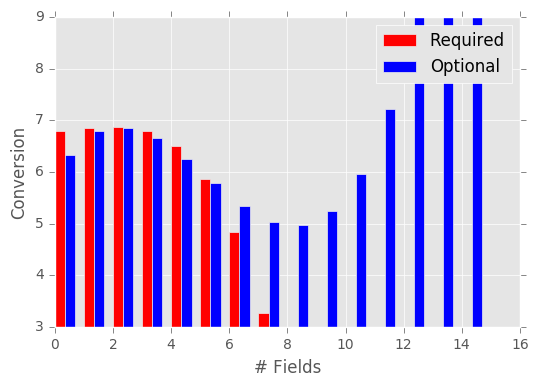

In [22]:
N = np.arange(15)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(N, req_field_predictions[0:15], width, color='r')
rects2 = ax.bar(N+width, opt_field_predictions[0:15], width, color='b')

ax.set_ylim(3, 9)
ax.set_ylabel("Conversion")
ax.set_xlabel("# Fields")
ax.legend((rects1[0], rects2[0]), ('Required', 'Optional'))

plt.show()

## Varying optional field targeted models

Found some orgs/forms that are outliers in terms of fields v conversion. One using amounts system to sell event registrations and thus has a large number of required custom fields, others with atypically high conversion with large numbers of custom fields, required & optional, presumably due to greater motivation on the part of the donor base or perhaps just more effective than average marketing efforts.

Additionally manually carving out thinner representation in higher conversion w/ higher field counts. Ie, 3 observations with 6 fields and 70% conversion rate. These are skewing the regression curve so they were removed. In total, 558680 observations out of 558680 original observations remain after removing both groups.

In [23]:
# copy & remove outliers
data_len = len(features)

nrm_data = data.copy()

del nrm_data['opt_fields3']

# remove outlier orgs & forms
nrm_data = nrm_data[nrm_data.org_x!=27626]
nrm_data = nrm_data[nrm_data.form!=820343]
nrm_data = nrm_data[nrm_data.form!=812122]
nrm_data = nrm_data[nrm_data.form!=711]
nrm_data = nrm_data[nrm_data.form!=87]
# remove higher field counts
nrm_data = nrm_data[nrm_data.req_fields<8]
nrm_data = nrm_data[nrm_data.opt_fields<10]
# remove higher conversion at higher field counts to reshape curve
rm_indexes = (nrm_data.opt_fields > 5) & (nrm_data.conversion > 60)
nrm_data = nrm_data[~rm_indexes]
rm_indexes = (nrm_data.opt_fields > 7) & (nrm_data.conversion > 40)
nrm_data = nrm_data[~rm_indexes]

nrm_data_len = len(nrm_data)

print str(nrm_data_len)+" observations out of "+str(data_len)+" original observations"

features = nrm_data.copy()
# remove irrelevant features
to_remove = ['amounts_system', 'id_x', 'org_x', 'form', 'timestamp', 'visits', 'mobile_visits', 'don_form_trans_count', 'don_form_trans_vol', 'id_y', 'base', 'org_y', 'total_visits', 'conversion']
for i_to_remove in to_remove:
    del features[i_to_remove]

# normalize features
features_scaled = preprocessing.scale(features)

nrm_mdl = linear_model.LinearRegression()
nrm_mdl.fit(features, nrm_data.conversion)
nrm_mdl_scaled = linear_model.LinearRegression()
nrm_mdl_scaled.fit(features_scaled, nrm_data.conversion)

558680 observations out of 569722 original observations


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

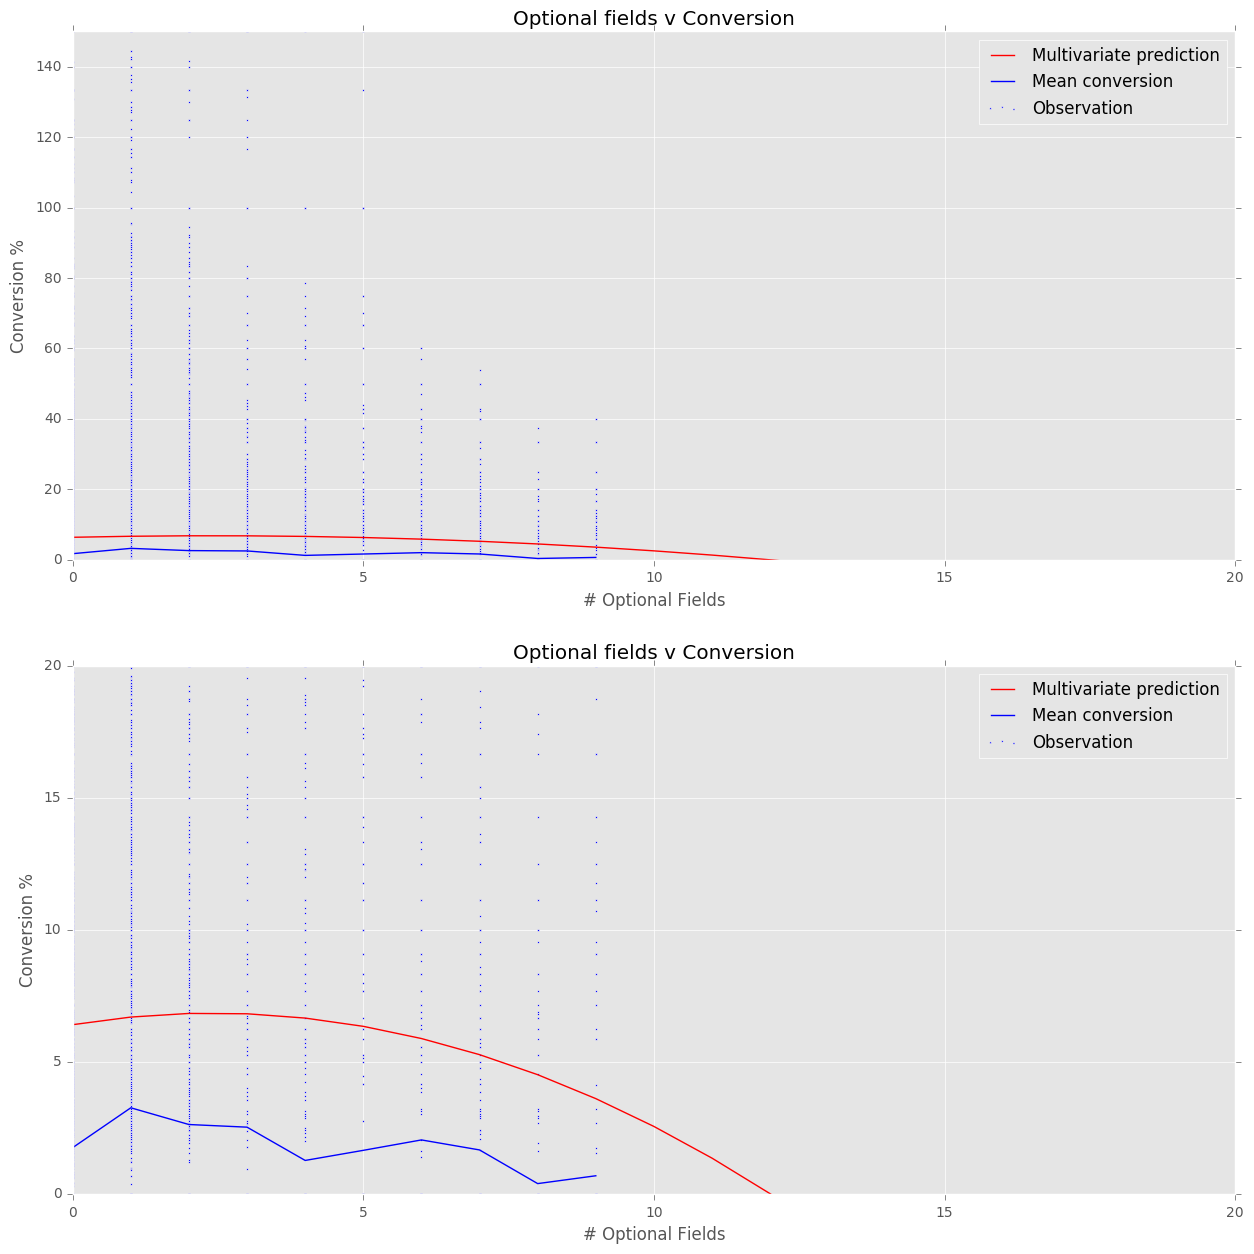

SCALED COEFFICIENTS
opt_fields: -8195960123.2
req_fields: -4255079243.73
donation_active: 0.5649766922
multirestriction_system: 0.710903167725
restrictions: 1.65829372406
pledges_count: 0.116732120514
pledge_active: -0.377219796181
permit_anonymous: -0.0597767829895
permit_mobile: 0.170493841171
permit_other_amount: 0.0606969594955
enable_donorlogins: 0.362924337387
collect_captcha: -4.76837158203e-07
day: 0.167265690863
month: -0.158969730139
restrictionsXmultirestriction: 0.835911750793
restrictions2: -3.71337154508
restrictions2Xmultirestriction: -1.04710829258
restrictions3: 2.09605628252
restrictions3Xmultirestriction: 0.650539070368
opt_fields2: -5.4647026062
req_fields2: 4.64990139008
req_fields3: -2.18223893642
fields: 2.78396987915
fields2: 9689037956.1
fields3: 5.13083040714
is_payday: -4.84825450182


In [24]:
# generate prediction data
example = nrm_data[nrm_data.conversion>0][1:2]

for i_to_remove in to_remove:
    del example[i_to_remove]
predictions = []
for i in range(0, 200):
    example['opt_fields'] = i
    example['opt_fields2'] = i*i
    example['fields'] = i+example['req_fields']
    example['fields2'] = example['fields']*example['fields']
    example['fields3'] = example['fields']*example['fields']*example['fields']
    predictions.append(nrm_mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(nrm_data[nrm_data.opt_fields==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(15,15))
plt.subplot(211)
plt.scatter(nrm_data.opt_fields, nrm_data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction", color="red")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion", color="blue")
plt.title("Optional fields v Conversion")
xlim(0, 20)
ylim(0, 150)
xlabel('# Optional Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(nrm_data.opt_fields, nrm_data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction", color="red")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion", color="blue")
plt.title("Optional fields v Conversion")
xlim(0, 20)
ylim(0, 20)
xlabel('# Optional Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()
print "SCALED COEFFICIENTS"
scaled_coefs = mdl_scaled.coef_
for i in range(0, len(features.columns.values)):
    print features.columns.values[i]+": "+str(scaled_coefs[i])
    
opt_field_predictions = predictions

Optional field prediction is matching mean trend with the most impactful features being

* opt_fields
* req_fields
* opt_fields^2
* req_fields^2
* req_fields^3
* fields
* fields^2
* fields^3

Weak factors appearing to be

* collect_captcha
* permit_other_amount
* permit_anonymous
* permit_mobile
* pledges_count
* pledge_active
* enable_donorlogins

It's worth pointing out that most of these weaker frontend settings flags have moved into the CMS system and I don't believe these form columns are being updated or paid attention to, which appears to be reflected in the feature weights.

Additionally, the donation_active feature doesn't appear to play much of a factor but more likely to just be too closesly tied to the filters that have already been executed upon this data set (ie, data set contains only one time transactions from forms with donation active set to positive value).

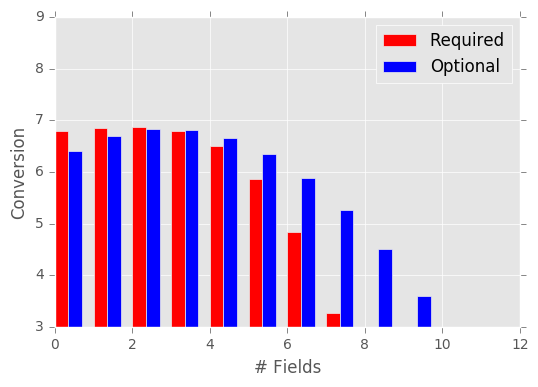

In [25]:
N = np.arange(12)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(N, req_field_predictions[0:12], width, color='r')
rects2 = ax.bar(N+width, opt_field_predictions[0:12], width, color='b')

ax.set_ylim(3, 9)
ax.set_ylabel("Conversion")
ax.set_xlabel("# Fields")
ax.legend((rects1[0], rects2[0]), ('Required', 'Optional'))

plt.show()

# Notes

It appears as though we have arrived at proportional model predictors for optional & required fields. Models look good, but in order to arrive at this I had to trim outliers and drop the cubed term for optional fields. Data points dropped were for

* Outliers proven to be mis-using the system (ie, event registration by way of the amounts system)
* Outliers with conversion rate well above the system-wide conversion mean, interpreted to have a hyper-motivated donor base or superior marketing capabilities
* Outliers manually trimmed to remove thin presence in higher order representation

The final measure is a little disconcerting as the outliers were not removed evenly across the entire data set (such as removing the top 5% for observations with fields between 0 and 6). I would like to perform an even outlier trim across observations prior to finalizing this.

This model is also using most form features and it would prove useful to examine the performance of the models with more isolated feature set rather than the rest of the system. There is no doubt a similarly performing model that only looks at these particular features (opt fields & req fields), and, given the goal is now to find conversion delta rather than conversion value, resource utilization could be optimized by only looking at what appear to be the strongest regression factors.

### Optional fields
* opt_fields
* opt_fields^2
* req_fields
* req_fields^2
* req_fields^3
* fields
* fields^2
* fields^3

# Trying isolated models

In [26]:
# copy & remove outliers
data_len = len(features)

nrm_data = data.copy()

del nrm_data['opt_fields3']

# remove outlier orgs & forms
nrm_data = nrm_data[nrm_data.org_x!=27626]
nrm_data = nrm_data[nrm_data.form!=820343]
nrm_data = nrm_data[nrm_data.form!=812122]
nrm_data = nrm_data[nrm_data.form!=711]
nrm_data = nrm_data[nrm_data.form!=87]
# remove higher field counts
nrm_data = nrm_data[nrm_data.req_fields<8]
nrm_data = nrm_data[nrm_data.opt_fields<10]
# remove higher conversion at higher field counts to reshape curve
rm_indexes = (nrm_data.opt_fields > 5) & (nrm_data.conversion > 60)
nrm_data = nrm_data[~rm_indexes]
rm_indexes = (nrm_data.opt_fields > 7) & (nrm_data.conversion > 40)
nrm_data = nrm_data[~rm_indexes]

nrm_data_len = len(nrm_data)

print str(nrm_data_len)+" observations out of "+str(data_len)+" original observations"

features = nrm_data[['opt_fields', 'req_fields', 'conversion']].copy()

features['opt_fields2'] = nrm_data['opt_fields']*nrm_data['opt_fields']
features['req_fields2'] = nrm_data['req_fields']*nrm_data['req_fields']
features['req_fields3'] = nrm_data['req_fields']*nrm_data['req_fields']*nrm_data['req_fields']
features['fields'] = nrm_data['opt_fields']+nrm_data['req_fields']
features['fields2'] = features['fields']*features['fields']
features['fields3'] = features['fields']*features['fields']*features['fields']

# normalize features
features_scaled = preprocessing.scale(features)

nrm_mdl = linear_model.LinearRegression()
nrm_mdl.fit(features, nrm_data.conversion)
nrm_mdl_scaled = linear_model.LinearRegression()
nrm_mdl_scaled.fit(features_scaled, nrm_data.conversion)

558680 observations out of 558680 original observations


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Opt fields isolated models

In [27]:
# generate prediction data
example = nrm_data[nrm_data.conversion>0][1:2]
example = example[['req_fields', 'opt_fields']].copy()

predictions = []
for i in range(0, 200):
    example['opt_fields'] = i
    example['opt_fields2'] = i*i
    example['req_fields2'] = example['req_fields']*example['req_fields']
    example['req_fields3'] = example['req_fields']*example['req_fields']*example['req_fields']
    example['fields'] = i+example['req_fields']
    example['fields2'] = example['fields']*example['fields']
    example['fields3'] = example['fields']*example['fields']*example['fields']
    predictions.append(nrm_mdl.predict(example)[0])
    
# generate mean conversion data set
mean_conversion = []
for i in range(0, 200):
    mean_conversion.append(nrm_data[nrm_data.opt_fields==i].conversion.mean())
    
# graph data, predictions, & mean conversion
plt.figure(1, figsize=(15,15))
plt.subplot(211)
plt.scatter(nrm_data.opt_fields, nrm_data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction", color="red")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion", color="blue")
plt.title("Optional fields v Conversion")
xlim(0, 20)
ylim(0, 150)
xlabel('# Optional Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.subplot(212)
plt.scatter(nrm_data.opt_fields, nrm_data.conversion, s=2, label="Observation")
plt.plot(range(0, 200), predictions, linewidth=1, label="Multivariate prediction", color="red")
plt.plot(range(0, 200), mean_conversion, linewidth=1, label="Mean conversion", color="blue")
plt.title("Optional fields v Conversion")
xlim(0, 20)
ylim(0, 20)
xlabel('# Optional Fields')
ylabel("Conversion %")
plt.legend(loc="upper right")

plt.show()
print "SCALED COEFFICIENTS"
scaled_coefs = mdl_scaled.coef_
for i in range(0, len(features.columns.values)):
    print features.columns.values[i]+": "+str(scaled_coefs[i])
    
opt_field_predictions = predictions

ValueError: shapes (1,8) and (9,) not aligned: 8 (dim 1) != 9 (dim 0)

In [ ]:
# OLS stats
nrm_features_scaled = features.copy()
del nrm_features_scaled['conversion']
features['Eins'] = np.ones((len(features), ))

Y = features.conversion[:-1]
X = nrm_features_scaled[:-1]
fit = sm.OLS(Y, X).fit()
print fit.summary()

In [ ]:
nrm_data.columns

In [ ]:
nrm_data.groupby('day').don_form_trans_vol.mean().plot()

In [ ]:
nrm_data.groupby('day').don_form_trans_count.mean().plot()

In [ ]:
nrm_data.groupby('day').conversion.mean().plot()